# Semantic Segmentation

In this exercise we will train an end-to-end convolutional neural network for semantic segmentation.
The goal of semantic segmentation is to classify the image on the pixel level, for each pixel
we want to determine the class of the object to which it belongs. This is different from image classification
which classifies an image as a whole and doesn't tell us the location of the objects.

Input image | Target image
-|-
![raw](assets/frankfurt_000000_014480.png) | ![raw](assets/frankfurt_000000_014480_labels.png)
![raw](assets/frankfurt_000001_005898.png) | ![raw](assets/frankfurt_000001_005898_labels.png)


## 1. Cityscapes dataset

[Cityscapes dataset](https://www.cityscapes-dataset.com/dataset-overview/) contains a diverse set of stereo video sequences recorded in street scenes from 50 different cities, with high quality pixel-level annotations. Dataset contains 2975 training and 500 validation images of size 2048x1024. The test set of 1000 images is evaluated on the server and benchmark is available [here](https://www.cityscapes-dataset.com/benchmarks/#scene-labeling-task). Here we will use downsampled images of size 384x160. The original dataset has 19 classes but we lowered that to 7 by uniting similar classes. This makes sense due to low visibility of very small objects in downsampled images. We also have ignore class which we need to ignore during training.

* Download the prepared dataset [here]() and extract it to the current directory. 

ID | Class | Color
-|-|-
0 | road | purple
1 | building | grey
2 | infrastructure | yellow
3 | nature | green
4 | sky | light blue
5 | person | red
6 | vehicle | dark blue
7 | ignore | black

## 2. Building the graph

Let's begin by importing all the modules and setting the fixed random seed.

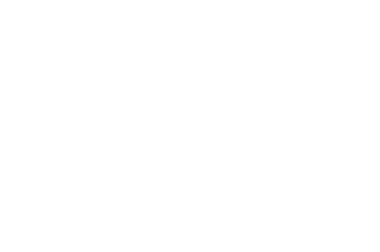

In [1]:
#%matplotlib notebook
%matplotlib inline
#%pylab inline
#pylab.rcParams['figure.figsize'] = (10, 6)

#%load_ext autoreload
#%autoreload 2

import time
from os.path import join

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import utils
from data import Dataset

tf.set_random_seed(31415)
plt.axis('off')
#plt.xticks([], [])
plt.rcParams["figure.figsize"] = (15, 5)

### Dataset

The `Dataset` class implements an iterator which returns the next batch data in each iteration. Data is already normalized to have zero mean and unit variance. The iteration is terminated when we reach the end of the dataset (one epoch).

In [2]:
batch_size = 10
num_classes = Dataset.num_classes
# create the Dataset for training and validation
train_data = Dataset('train', batch_size)
val_data = Dataset('val', batch_size, shuffle=False)

print('Train shape:', train_data.x.shape)
print('Validation shape:', val_data.x.shape)

print('mean = ', train_data.x.mean((0,1,2)))
print('std = ', train_data.x.std((0,1,2)))

# store the input image dimensions
height = train_data.height
width = train_data.width
channels = train_data.channels

Train shape: (2975, 160, 384, 3)
Validation shape: (500, 160, 384, 3)
mean =  [-0.03841928 -0.04215339 -0.05894543]
std =  [ 1.01808784  1.02022915  1.02732566]


### Inputs

First, we will create input placeholders for Tensorflow computational graph of the model. For a supervised learning model, we need to declare placeholders which will hold input images (x) and target labels (y) of the mini-batches as
we feed them to the network.

In [3]:
# create placeholders for inputs
def build_inputs():
    with tf.name_scope('data'):
        x = tf.placeholder(tf.float32, shape=(None, height, width, channels), name='rgb_images')
        y = tf.placeholder(tf.int32, shape=(None, height, width), name='labels')
    return x, y

### Model

Now we can define the computational graph. Here we will heavily use [`tf.layers`](https://www.tensorflow.org/api_docs/python/tf/layers) high level API.

In [4]:
# helper function which applies conv2d + ReLU
def conv(x, num_maps, k=3):
    x = tf.layers.conv2d(x, num_maps, k, padding='same')
    x = tf.nn.relu(x)
    return x

# helper function for 2x2 max pooling with stride=2
def pool(x):
    return tf.layers.max_pooling2d(x, pool_size=2, strides=2, padding='same')

# this functions takes the input placeholder and the number of classes and builds the model
def build_model(x, num_classes):
    input_size = x.get_shape().as_list()[1:3]
    block_sizes = [64, 64, 64, 64]
    x = conv(x, 32, k=3)
    for i, size in enumerate(block_sizes):
        with tf.name_scope('block'+str(i)):
            x = pool(x)
            x = conv(x, size)
            # x = conv(x, size)
    print(x)
    with tf.name_scope('logits'):
        x = tf.layers.conv2d(x, num_classes, 1, padding='same')
        x = tf.image.resize_bilinear(x, input_size, name='upsample_logits')
    return x

### Loss

Now we are going to implement the `build_loss` funcion which will create operations for our loss and return the final `tf.Tensor` holding the scalar loss value.
Because segmentation is just classificaion on a pixel level we can again use the cross-entropy loss function \\(L\\) between the target one-hot distribution \\( \mathbf{y} \\) and the predicted distribution from a softmax layer \\( \mathbf{s} \\). But compared to image clasificaion here we need to define the loss at each pixel. Below are the equations describing the loss for one example (one pixel in our case).
$$
L = - \sum_{i=1}^{C} y_i log(s_j(\mathbf{x})) \\
s_i(\mathbf{x}) = \frac{e^{x_i}}{\sum_{j=1}^{C} e^{x_j}} \\
$$

In [5]:
def build_loss(logits, y):
  with tf.name_scope('loss'):
    y = tf.reshape(y, shape=[-1])
    logits = tf.reshape(logits, [-1, num_classes])

    mask = y < num_classes
    y = tf.boolean_mask(y, mask)
    logits = tf.boolean_mask(logits, mask)

    y_one_hot = tf.one_hot(y, num_classes)
    xent = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_one_hot)

    xent = tf.reduce_mean(xent)
    tf.summary.scalar('cross_entropy', xent)
    return xent

### Putting it all together

Now we can use all the building blocks from above and construct the whole Tensorflow graph in just a couple of lines.

In [6]:
x, y = build_inputs()
logits = build_model(x, num_classes)
loss = build_loss(logits, y)
y_pred = tf.argmax(logits, axis=3, output_type=tf.int32)

Tensor("block3/Relu:0", shape=(?, 10, 24, 64), dtype=float32)


## 3. Training the model

### Validation

We usually evaluate the semantic segmentation results with [Intersection over Union](https://en.wikipedia.org/wiki/Jaccard_index) measure (IoU aka Jaccard index). Note that accurracy we used on MNIST image classification problem is a bad measure in this case because semantic segmentation datasets are often heavily imbalanced. First we compute IoU for each class in one-vs-all fashion (shown below) and then take the mean IoU (mIoU) over all classes. By taking the mean we are treating all classes as equally important.
$$
IOU = \frac{TP}{TP + FN + FP}
$$

![iou](assets/iou.png)

In [7]:
def validate(data, x, y, y_pred, loss, draw_steps=0):
    print('\nValidation phase:')
    conf_mat = np.zeros((num_classes, num_classes), dtype=np.uint64) 
    for i, (x_np, y_np, names) in enumerate(data):
        start_time = time.time()
        loss_np, y_pred_np = sess.run([loss, y_pred],
          feed_dict={x: x_np, y: y_np})

        duration = time.time() - start_time
        batch_conf_mat = confusion_matrix(y_np.reshape(-1), y_pred_np.reshape(-1))
        batch_conf_mat = batch_conf_mat[:-1,:-1].astype(np.uint64)
        conf_mat += batch_conf_mat

        for j in range(min(draw_steps, batch_size)):
            img_pred = utils.colorize_labels(y_pred_np[j], Dataset.class_info)
            img_true = utils.colorize_labels(y_np[j], Dataset.class_info)
            img_raw = data.get_img(names[j])
            img = np.concatenate((img_raw, img_true, img_pred), axis=1)
            plt.imshow(img)
            plt.show()
            draw_steps -= 1

        if i % 10 == 0:
            string = 'batch %03d loss = %.2f  (%.1f images/sec)' % \
            (i, loss_np, x_np.shape[0] / duration)
            print(string)
    print(conf_mat)
    return utils.print_stats(conf_mat, 'Validation', Dataset.class_info)

### Training

/usr/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Training phase:
00:00:01: epoch 1 / 30, iter 00000, loss = 2.01  (17.8 images/sec)
00:00:01: epoch 1 / 30, iter 00020, loss = 1.34  (389.3 images/sec)
00:00:02: epoch 1 / 30, iter 00040, loss = 1.05  (396.1 images/sec)
00:00:02: epoch 1 / 30, iter 00060, loss = 0.73  (377.9 images/sec)
00:00:03: epoch 1 / 30, iter 00080, loss = 0.72  (373.9 images/sec)
00:00:03: epoch 1 / 30, iter 00100, loss = 0.82  (380.8 images/sec)
00:00:04: epoch 1 / 30, iter 00120, loss = 0.68  (396.0 images/sec)
00:00:04: epoch 1 / 30, iter 00140, loss = 0.62  (380.2 images/sec)
00:00:05: epoch 1 / 30, iter 00160, loss = 0.59  (379.2 images/sec)
00:00:05: epoch 1 / 30, iter 00180, loss = 0.58  (349.9 images/sec)
00:00:06: epoch 1 / 30, iter 00200, loss = 0.61  (392.4 images/sec)
00:00:06: epoch 1 / 30, iter 00220, loss = 0.75  (391.2 images/sec)
00:00:07: epoch 1 / 30, iter 00240, loss = 0.57  (379.2 images/sec)
00:00:07: epoch 1 / 30, iter 00260, loss = 0.54  (388.8 images/sec)
00:00:08: epoch 1 / 30, iter 002

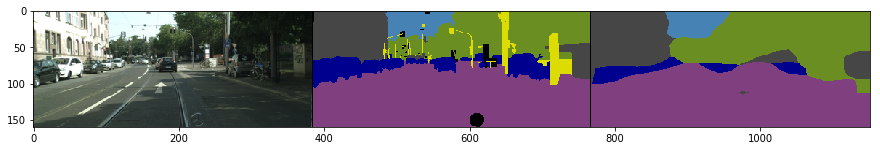

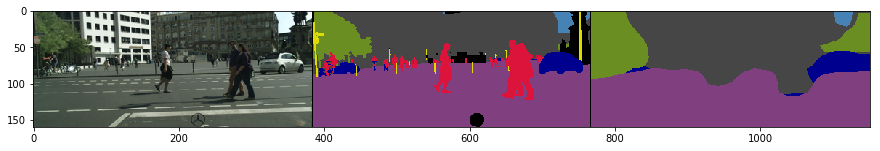

batch 000 loss = 0.58  (627.1 images/sec)
batch 010 loss = 0.53  (868.8 images/sec)
batch 020 loss = 0.66  (818.8 images/sec)
batch 030 loss = 0.53  (823.0 images/sec)
batch 040 loss = 0.61  (810.0 images/sec)
[[11278685   241227      111   135155       58       53   105333]
 [  179415  5519868        0   950627    55258       32   161656]
 [   89996   537953       33   318757     7714       26    31466]
 [  112934   486858        4  4813998    21289       10    31764]
 [       0   158197        0    80983   667572        0      119]
 [   42916   307653       57    88426        0      373    39563]
 [  374612   601948      164   498602     4493       19  1076203]]

 Validation  evaluation metrics:
	road IoU accuracy = 89.79 %
	building IoU accuracy = 59.99 %
	infrastructure IoU accuracy = 0.00 %
	nature IoU accuracy = 63.85 %
	sky IoU accuracy = 67.05 %
	person IoU accuracy = 0.08 %
	vehicle IoU accuracy = 36.78 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 45.36 %
Validatio

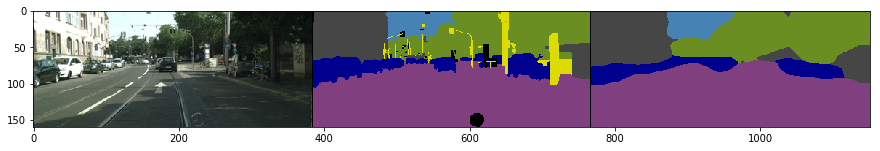

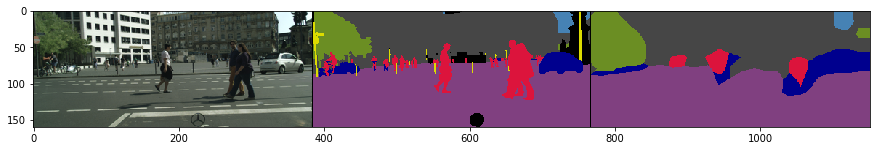

batch 000 loss = 0.49  (797.5 images/sec)
batch 010 loss = 0.51  (865.8 images/sec)
batch 020 loss = 0.59  (858.7 images/sec)
batch 030 loss = 0.41  (862.7 images/sec)
batch 040 loss = 0.45  (885.8 images/sec)
[[11445665   111508      176    40163       74     6599   156437]
 [  269281  5884472      156   409254    56571     6532   240590]
 [  116780   571289      270   211997     8592     5187    71830]
 [  168923   706969      155  4462985    37656     1279    88890]
 [       4   142561        0    36326   727183        0      797]
 [   56429   250463      324    36913        0    37992    96867]
 [  324821   403699      357   132966     2592     4186  1687420]]

 Validation  evaluation metrics:
	road IoU accuracy = 90.15 %
	building IoU accuracy = 65.00 %
	infrastructure IoU accuracy = 0.03 %
	nature IoU accuracy = 70.46 %
	sky IoU accuracy = 71.83 %
	person IoU accuracy = 7.56 %
	vehicle IoU accuracy = 52.54 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 51.08 %
Validatio

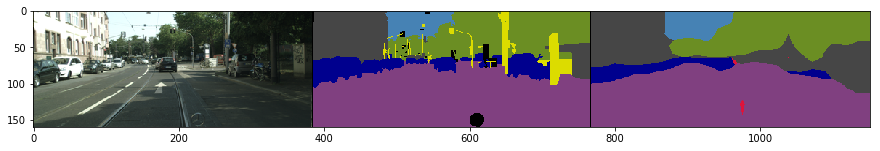

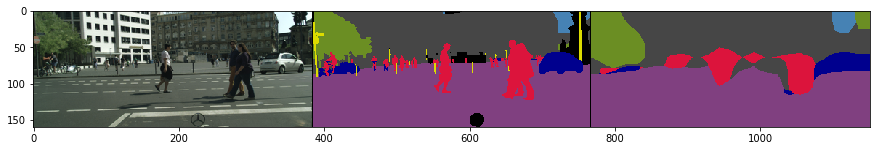

batch 000 loss = 0.49  (759.9 images/sec)
batch 010 loss = 0.51  (861.4 images/sec)
batch 020 loss = 0.58  (870.8 images/sec)
batch 030 loss = 0.44  (843.1 images/sec)
batch 040 loss = 0.42  (827.6 images/sec)
[[11424900   178887      199    17723      419    46509    91985]
 [  200229  6182826      361   224877   159534    36969    62060]
 [   99870   653483      767   154324    14922    33548    29031]
 [  175239  1043191      670  4106457    83768    12339    45193]
 [       3    50677       39    24304   831788        2       58]
 [   48293   259102      202    20247       22   126653    24469]
 [  305697   689727      903    67599    11929    84387  1395799]]

 Validation  evaluation metrics:
	road IoU accuracy = 90.75 %
	building IoU accuracy = 63.47 %
	infrastructure IoU accuracy = 0.08 %
	nature IoU accuracy = 68.72 %
	sky IoU accuracy = 70.64 %
	person IoU accuracy = 18.28 %
	vehicle IoU accuracy = 49.69 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 51.66 %
Validati

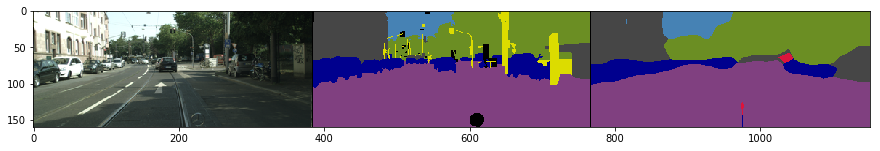

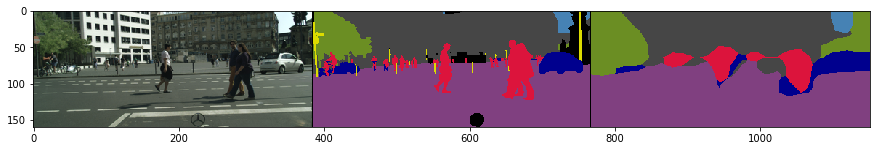

batch 000 loss = 0.45  (807.4 images/sec)
batch 010 loss = 0.47  (876.0 images/sec)
batch 020 loss = 0.55  (861.3 images/sec)
batch 030 loss = 0.39  (853.0 images/sec)
batch 040 loss = 0.43  (846.2 images/sec)
[[11431458   151036      683    63719       76    24568    89082]
 [  170659  5744746      362   668890   151768    22644   107787]
 [  100636   517666     1734   287569    13396    19842    45102]
 [  108060   381738      933  4899279    35831     3593    37423]
 [      69    46436       51    62187   797583        4      541]
 [   54635   193496      668    61170      440   115810    52769]
 [  294354   398572     1090   224308     8074    30306  1599337]]

 Validation  evaluation metrics:
	road IoU accuracy = 91.53 %
	building IoU accuracy = 67.14 %
	infrastructure IoU accuracy = 0.18 %
	nature IoU accuracy = 71.68 %
	sky IoU accuracy = 71.44 %
	person IoU accuracy = 19.97 %
	vehicle IoU accuracy = 55.36 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 53.90 %
Validati

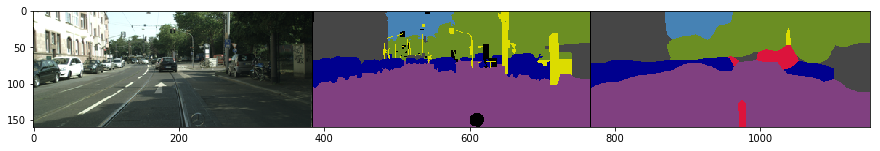

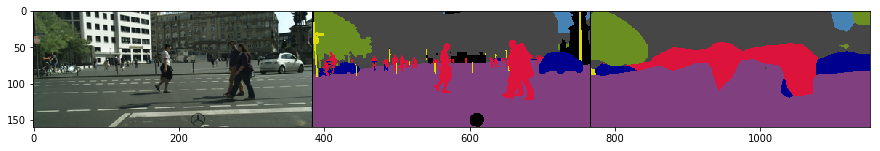

batch 000 loss = 0.45  (839.2 images/sec)
batch 010 loss = 0.49  (866.3 images/sec)
batch 020 loss = 0.53  (871.2 images/sec)
batch 030 loss = 0.37  (864.3 images/sec)
batch 040 loss = 0.37  (875.8 images/sec)
[[11287946   129449     3015    38723       50    78811   222628]
 [  132173  6098586     4682   291552    64819   157672   117372]
 [   97959   547856     9614   194137     9919    84368    42092]
 [  108532   745705     7571  4476990    37059    43842    47158]
 [     200    83787      564    44240   776671      671      738]
 [   39680   116504     1855    23999       77   261960    34913]
 [  170198   390631     4020    92735     3411   165563  1729483]]

 Validation  evaluation metrics:
	road IoU accuracy = 91.70 %
	building IoU accuracy = 68.67 %
	infrastructure IoU accuracy = 0.95 %
	nature IoU accuracy = 72.77 %
	sky IoU accuracy = 75.98 %
	person IoU accuracy = 25.94 %
	vehicle IoU accuracy = 57.25 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 56.18 %
Validati

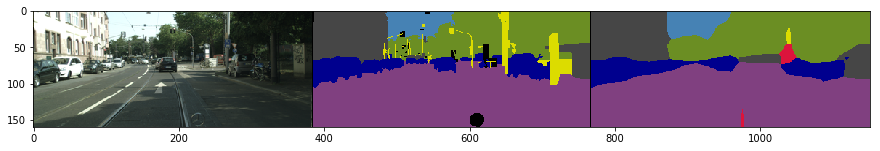

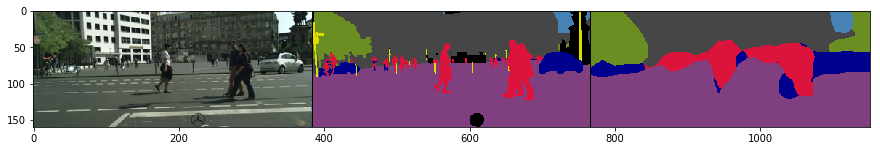

batch 000 loss = 0.43  (638.3 images/sec)
batch 010 loss = 0.45  (864.1 images/sec)
batch 020 loss = 0.52  (850.7 images/sec)
batch 030 loss = 0.33  (851.6 images/sec)
batch 040 loss = 0.39  (875.3 images/sec)
[[11372774    69216     3597    42859       70    44555   227551]
 [  194579  5386421     4754   636399    87528   138591   418584]
 [   92026   414513     9332   279989    11951    60792   117342]
 [  110704   275776     4429  4909319    30634    21753   114242]
 [      53    45598      185    63833   796074       32     1096]
 [   38169    78281     1376    37124      143   198279   125616]
 [  154220   151197     1265   118074     4848    46169  2080268]]

 Validation  evaluation metrics:
	road IoU accuracy = 92.08 %
	building IoU accuracy = 68.17 %
	infrastructure IoU accuracy = 0.93 %
	nature IoU accuracy = 73.88 %
	sky IoU accuracy = 76.40 %
	person IoU accuracy = 25.07 %
	vehicle IoU accuracy = 58.43 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 56.42 %
Validati

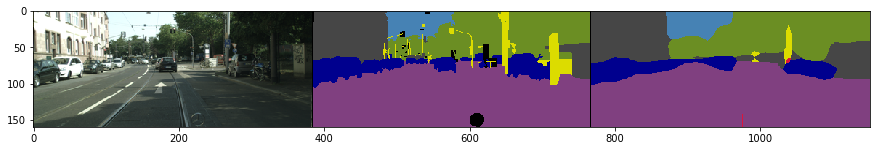

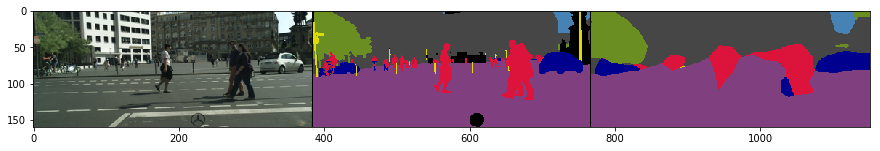

batch 000 loss = 0.40  (856.8 images/sec)
batch 010 loss = 0.44  (841.7 images/sec)
batch 020 loss = 0.48  (864.4 images/sec)
batch 030 loss = 0.34  (858.6 images/sec)
batch 040 loss = 0.36  (855.5 images/sec)
[[11487246   112843     9194    26787       86    28489    95977]
 [  158885  6204806     9288   285762    86452    29588    92075]
 [  106499   589866    24491   190632    12475    21460    40522]
 [  138202   696643    14702  4503636    54381     7411    51882]
 [     121    57983      322    31414   816603       20      408]
 [   53696   183521     8824    26384       88   159763    46712]
 [  238820   414344    13484    79171     4537    48528  1757157]]

 Validation  evaluation metrics:
	road IoU accuracy = 92.22 %
	building IoU accuracy = 69.54 %
	infrastructure IoU accuracy = 2.35 %
	nature IoU accuracy = 73.75 %
	sky IoU accuracy = 76.68 %
	person IoU accuracy = 26.00 %
	vehicle IoU accuracy = 60.94 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 57.35 %
Validati

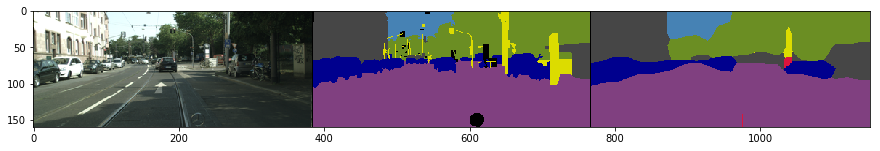

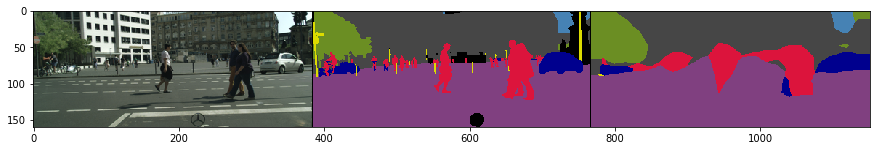

batch 000 loss = 0.41  (747.9 images/sec)
batch 010 loss = 0.44  (862.4 images/sec)
batch 020 loss = 0.49  (820.6 images/sec)
batch 030 loss = 0.33  (836.8 images/sec)
batch 040 loss = 0.36  (838.6 images/sec)
[[11447465   142342     8390    38775       60    37208    86382]
 [  135366  6195130     8621   338845    48378    36403   104113]
 [   94578   580456    24232   211430    10931    29573    34745]
 [  101386   569007    12623  4703576    37204     7770    35291]
 [     109    79584      584    47010   778541       38     1005]
 [   46044   177140     6109    31126       39   181515    37015]
 [  212068   449504    13838    96104     1286    59241  1724000]]

 Validation  evaluation metrics:
	road IoU accuracy = 92.69 %
	building IoU accuracy = 69.88 %
	infrastructure IoU accuracy = 2.34 %
	nature IoU accuracy = 75.50 %
	sky IoU accuracy = 77.48 %
	person IoU accuracy = 27.96 %
	vehicle IoU accuracy = 60.39 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 58.04 %
Validati

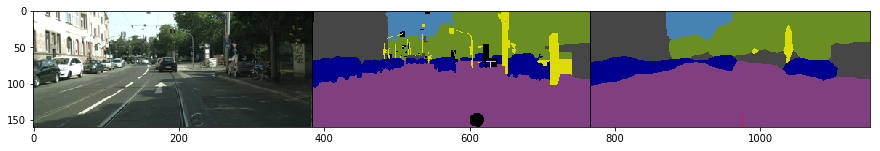

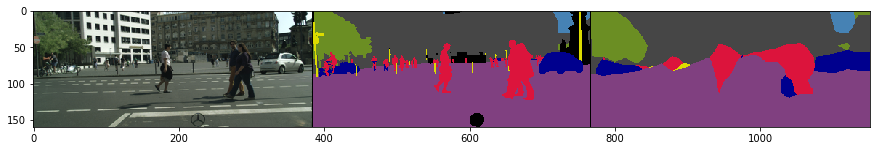

batch 000 loss = 0.40  (879.6 images/sec)
batch 010 loss = 0.43  (871.7 images/sec)
batch 020 loss = 0.48  (860.5 images/sec)
batch 030 loss = 0.31  (855.2 images/sec)
batch 040 loss = 0.34  (870.7 images/sec)
[[11457445   114216    15421    34928      127    29331   109154]
 [  132930  6217543    14533   267304    80772    23784   129990]
 [   89277   595529    37945   181837    13095    18173    50089]
 [  116628   652830    22417  4562487    46759     5700    60036]
 [      34    47896      749    38643   819091        0      458]
 [   47752   187652    11264    21468      145   155281    55426]
 [  202524   336327    14689    63982     3908    39412  1895199]]

 Validation  evaluation metrics:
	road IoU accuracy = 92.77 %
	building IoU accuracy = 70.64 %
	infrastructure IoU accuracy = 3.56 %
	nature IoU accuracy = 75.10 %
	sky IoU accuracy = 77.88 %
	person IoU accuracy = 26.08 %
	vehicle IoU accuracy = 64.00 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 58.58 %
Validati

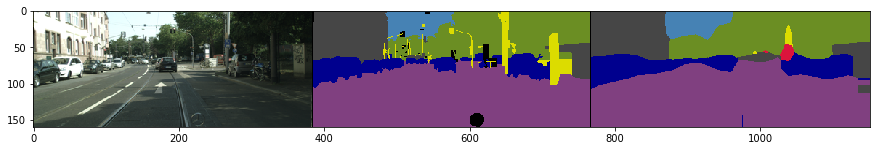

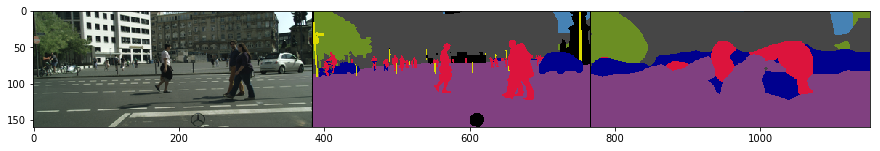

batch 000 loss = 0.42  (792.4 images/sec)
batch 010 loss = 0.44  (873.0 images/sec)
batch 020 loss = 0.48  (866.8 images/sec)
batch 030 loss = 0.30  (829.8 images/sec)
batch 040 loss = 0.32  (847.4 images/sec)
[[11375512    61565     3578    31471      133    27099   261264]
 [  165703  5655933    21710   357252   100650    73987   491621]
 [  104266   456622    33568   216002    13799    35411   126277]
 [  125913   425812    13598  4681439    44407    17788   157900]
 [       2    34587     1979    43036   824869       39     2359]
 [   50056    92482     2439    22523      285   198087   113116]
 [  136179   117782     2648    51220     1727    41550  2204935]]

 Validation  evaluation metrics:
	road IoU accuracy = 92.16 %
	building IoU accuracy = 70.21 %
	infrastructure IoU accuracy = 3.25 %
	nature IoU accuracy = 75.65 %
	sky IoU accuracy = 77.24 %
	person IoU accuracy = 29.35 %
	vehicle IoU accuracy = 59.45 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 58.19 %
Validati

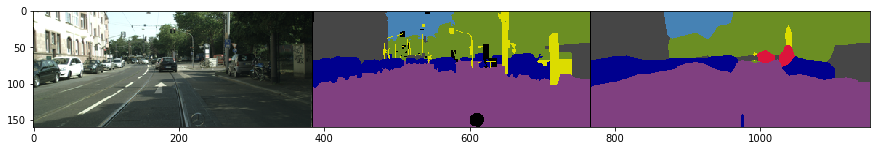

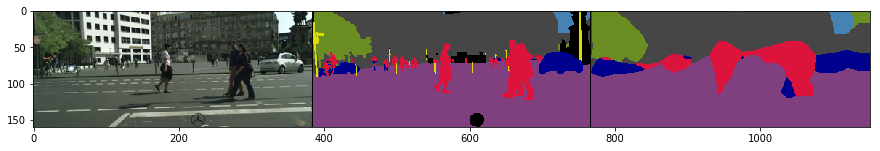

batch 000 loss = 0.39  (758.6 images/sec)
batch 010 loss = 0.42  (864.8 images/sec)
batch 020 loss = 0.46  (867.0 images/sec)
batch 030 loss = 0.29  (864.9 images/sec)
batch 040 loss = 0.32  (852.8 images/sec)
[[11452243    95109     6501    32559       83    43269   130858]
 [  128192  6032354     9446   384243    82165    68918   161538]
 [   95619   520283    25498   220962    13005    43681    66897]
 [  112823   502438     9877  4717571    31814    18555    73779]
 [      25    38564      743    56702   810163       54      620]
 [   43099   112139     2908    24551       82   230858    65351]
 [  165193   246894     4018    67689     3263    65689  2003295]]

 Validation  evaluation metrics:
	road IoU accuracy = 93.07 %
	building IoU accuracy = 71.97 %
	infrastructure IoU accuracy = 2.50 %
	nature IoU accuracy = 75.44 %
	sky IoU accuracy = 78.10 %
	person IoU accuracy = 32.10 %
	vehicle IoU accuracy = 65.57 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 59.82 %
Validati

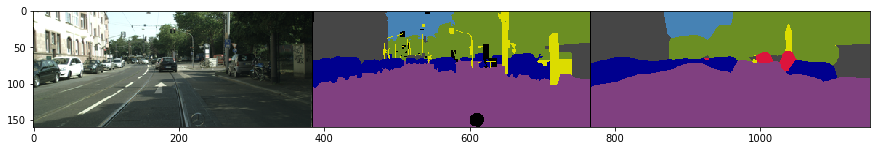

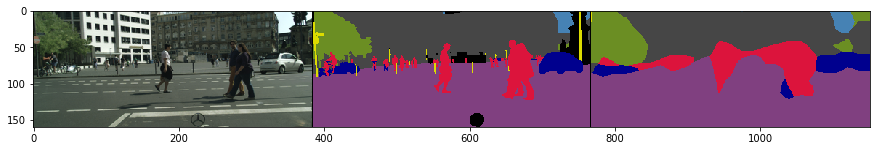

batch 000 loss = 0.38  (802.8 images/sec)
batch 010 loss = 0.40  (872.1 images/sec)
batch 020 loss = 0.46  (883.7 images/sec)
batch 030 loss = 0.29  (862.5 images/sec)
batch 040 loss = 0.33  (825.6 images/sec)
[[11451547    65891    11411    41309       99    53816   136549]
 [  138673  5923724    20751   483193   106743    82532   111240]
 [   97077   483614    40665   254837    12491    53485    43776]
 [  104020   315002    13833  4936714    36778    20092    40418]
 [      51    38664     1435    47990   818394       34      303]
 [   41899   103579     2934    31632       85   260173    38686]
 [  147724   250069     8635   121194     8278   107018  1913123]]

 Validation  evaluation metrics:
	road IoU accuracy = 93.18 %
	building IoU accuracy = 72.92 %
	infrastructure IoU accuracy = 3.89 %
	nature IoU accuracy = 76.57 %
	sky IoU accuracy = 76.39 %
	person IoU accuracy = 32.69 %
	vehicle IoU accuracy = 65.36 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 60.14 %
Validati

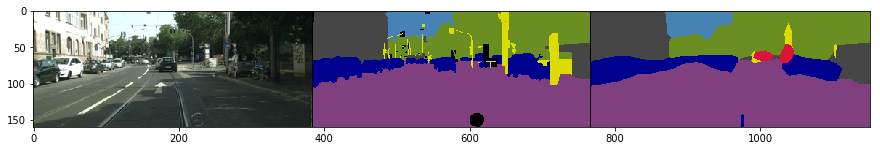

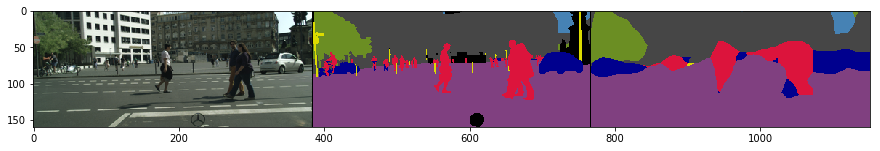

batch 000 loss = 0.38  (732.3 images/sec)
batch 010 loss = 0.41  (863.3 images/sec)
batch 020 loss = 0.45  (858.5 images/sec)
batch 030 loss = 0.28  (856.2 images/sec)
batch 040 loss = 0.31  (862.4 images/sec)
[[11461793    66339    10808    22539       58    26890   172195]
 [  138719  6061721    21686   300257    46022    52582   245869]
 [   96811   503881    48743   199538    11161    30931    94880]
 [  127812   455401    22105  4686540    36844    12878   125277]
 [       3    72725      781    42087   790229        4     1042]
 [   48287   101871     5201    21353       75   188138   114063]
 [  133014   189897     6915    46083     1286    32482  2146364]]

 Validation  evaluation metrics:
	road IoU accuracy = 93.15 %
	building IoU accuracy = 73.41 %
	infrastructure IoU accuracy = 4.63 %
	nature IoU accuracy = 76.84 %
	sky IoU accuracy = 78.84 %
	person IoU accuracy = 29.64 %
	vehicle IoU accuracy = 64.86 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 60.20 %
Validati

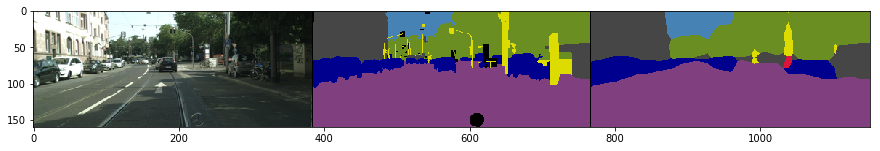

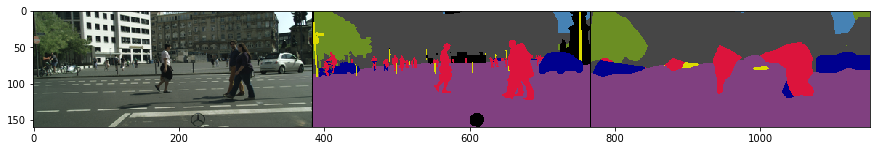

batch 000 loss = 0.39  (815.9 images/sec)
batch 010 loss = 0.39  (864.3 images/sec)
batch 020 loss = 0.47  (866.6 images/sec)
batch 030 loss = 0.28  (858.3 images/sec)
batch 040 loss = 0.31  (855.9 images/sec)
[[11466263    85983    31406    36026       79    30434   110431]
 [  140334  6180024    29855   322401    66357    23842   104043]
 [   84743   545477    69427   208972    12654    18542    46130]
 [  110749   457551    29602  4775853    38627     6370    48105]
 [       1    49062      890    42005   814686        0      227]
 [   45501   169210    12054    26899       87   168573    56664]
 [  165161   295110    16814    77352     4318    39249  1958037]]

 Validation  evaluation metrics:
	road IoU accuracy = 93.17 %
	building IoU accuracy = 72.97 %
	infrastructure IoU accuracy = 6.27 %
	nature IoU accuracy = 77.27 %
	sky IoU accuracy = 79.17 %
	person IoU accuracy = 28.22 %
	vehicle IoU accuracy = 67.02 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 60.58 %
Validati

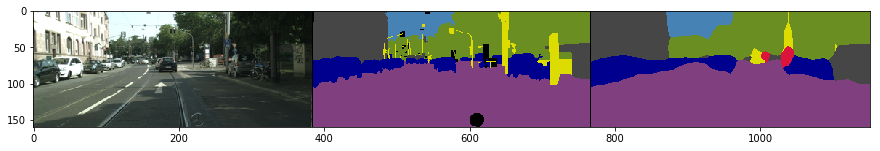

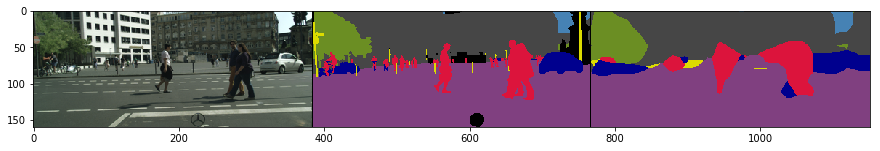

batch 000 loss = 0.38  (764.1 images/sec)
batch 010 loss = 0.40  (862.6 images/sec)
batch 020 loss = 0.45  (853.1 images/sec)
batch 030 loss = 0.28  (863.6 images/sec)
batch 040 loss = 0.31  (872.2 images/sec)
[[11445763    88290    25277    31467       25    31901   137899]
 [  112602  6192040    33054   303434    31295    44291   150140]
 [   83603   523485    80023   202201     9519    26825    60289]
 [  111834   468538    34539  4747199    26125    13203    65419]
 [       6    97536     3048    51559   753554       14     1154]
 [   44919   118582    11640    23199       68   209871    70709]
 [  141969   220628    18570    68766      593    44661  2060854]]

 Validation  evaluation metrics:
	road IoU accuracy = 93.39 %
	building IoU accuracy = 73.86 %
	infrastructure IoU accuracy = 7.20 %
	nature IoU accuracy = 77.22 %
	sky IoU accuracy = 77.33 %
	person IoU accuracy = 32.80 %
	vehicle IoU accuracy = 67.75 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 61.36 %
Validati

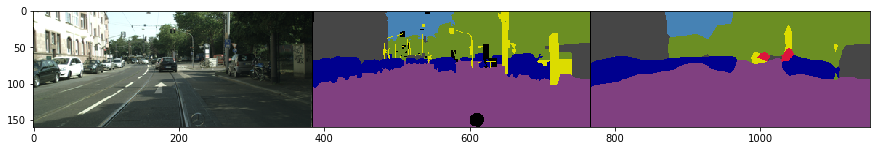

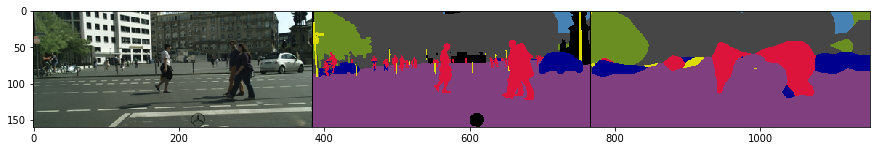

batch 000 loss = 0.37  (758.1 images/sec)
batch 010 loss = 0.38  (878.1 images/sec)
batch 020 loss = 0.45  (877.2 images/sec)
batch 030 loss = 0.28  (851.7 images/sec)
batch 040 loss = 0.33  (867.5 images/sec)
[[11487304    39608    28903    46213       54    30362   128178]
 [  158502  5699984    82997   626667    53674    64948   180084]
 [   97126   399389   115747   273320    10382    32622    57359]
 [  101942   223902    32612  5022257    23036    13177    49931]
 [       8    54494     3882    62851   785019        6      611]
 [   50489    91355    15889    39285      100   218205    63665]
 [  143527   175488    23964   112152     2802    53746  2044362]]

 Validation  evaluation metrics:
	road IoU accuracy = 93.30 %
	building IoU accuracy = 72.60 %
	infrastructure IoU accuracy = 9.86 %
	nature IoU accuracy = 75.78 %
	sky IoU accuracy = 78.74 %
	person IoU accuracy = 32.38 %
	vehicle IoU accuracy = 67.34 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 61.43 %
Validati

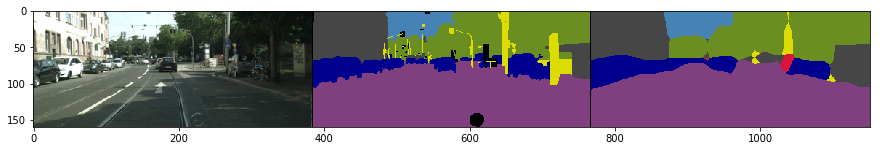

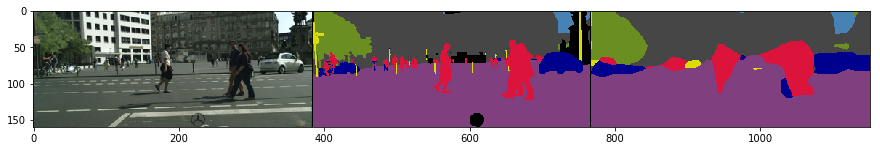

batch 000 loss = 0.38  (832.0 images/sec)
batch 010 loss = 0.39  (853.6 images/sec)
batch 020 loss = 0.45  (835.7 images/sec)
batch 030 loss = 0.28  (843.7 images/sec)
batch 040 loss = 0.31  (830.9 images/sec)
[[11363213   109168    25603    53831      112    38223   170472]
 [   97547  6091783    35527   397086    79995    37571   127347]
 [   76122   501695    83136   229954    13397    27680    53961]
 [   78079   350249    30023  4901944    51575    10437    44550]
 [       1    44925     1868    31605   827755        0      717]
 [   39669   135798    10075    31205      127   210647    51467]
 [  106740   256924    18683    99629     3365    57038  2013662]]

 Validation  evaluation metrics:
	road IoU accuracy = 93.46 %
	building IoU accuracy = 73.70 %
	infrastructure IoU accuracy = 7.51 %
	nature IoU accuracy = 77.68 %
	sky IoU accuracy = 78.43 %
	person IoU accuracy = 32.41 %
	vehicle IoU accuracy = 67.02 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 61.46 %
Validati

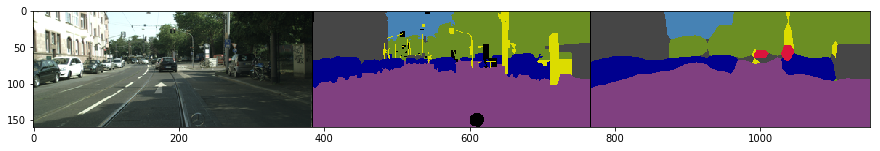

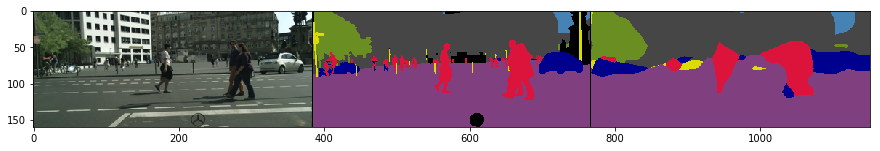

batch 000 loss = 0.37  (804.7 images/sec)
batch 010 loss = 0.39  (859.0 images/sec)
batch 020 loss = 0.44  (849.8 images/sec)
batch 030 loss = 0.26  (855.2 images/sec)
batch 040 loss = 0.29  (869.0 images/sec)
[[11441078    81440    23301    50615      104    31612   132472]
 [  119580  6140951    35955   283291    66201    43112   177766]
 [   81462   508747    88765   200043    13028    25476    68424]
 [   83667   458391    30661  4758782    49755    12784    72817]
 [       1    53016     1617    30039   821183        0     1015]
 [   44442   116730     9534    22143       91   205499    80549]
 [  134412   188356    11905    65372     1627    37116  2117253]]

 Validation  evaluation metrics:
	road IoU accuracy = 93.59 %
	building IoU accuracy = 74.22 %
	infrastructure IoU accuracy = 8.08 %
	nature IoU accuracy = 77.78 %
	sky IoU accuracy = 79.14 %
	person IoU accuracy = 32.67 %
	vehicle IoU accuracy = 68.54 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 62.00 %
Validati

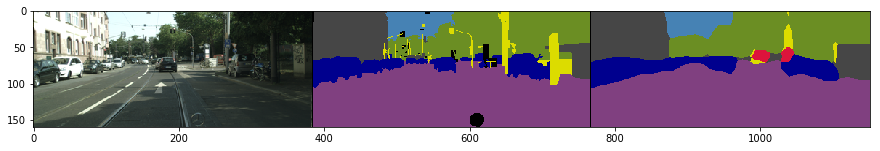

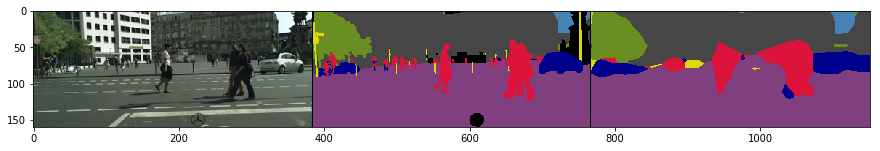

batch 000 loss = 0.37  (780.6 images/sec)
batch 010 loss = 0.38  (875.2 images/sec)
batch 020 loss = 0.43  (853.6 images/sec)
batch 030 loss = 0.26  (836.9 images/sec)
batch 040 loss = 0.29  (827.1 images/sec)
[[11444695    60448    25081    32873       67    37646   159812]
 [  148342  6040350    49406   316363    63543    59553   189299]
 [   82773   473548   102902   201677    12184    33424    79437]
 [  105225   389347    42347  4791371    34889    15541    88137]
 [       3    49725     2274    44389   809315        9     1156]
 [   39094    92232     9511    21488       86   223656    92921]
 [  118585   175164    13928    55825     2059    40134  2150346]]

 Validation  evaluation metrics:
	road IoU accuracy = 93.39 %
	building IoU accuracy = 74.50 %
	infrastructure IoU accuracy = 9.12 %
	nature IoU accuracy = 78.04 %
	sky IoU accuracy = 79.37 %
	person IoU accuracy = 33.62 %
	vehicle IoU accuracy = 67.90 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 62.28 %
Validati

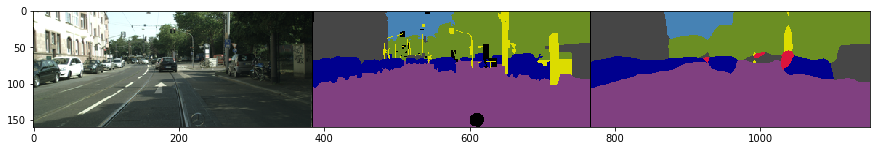

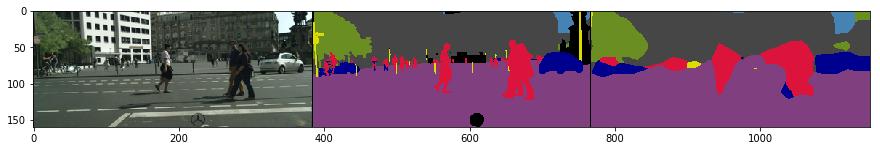

batch 000 loss = 0.36  (605.0 images/sec)
batch 010 loss = 0.38  (851.0 images/sec)
batch 020 loss = 0.44  (863.7 images/sec)
batch 030 loss = 0.26  (854.3 images/sec)
batch 040 loss = 0.29  (856.8 images/sec)
[[11448881    99285    15460    38283      119    40910   117684]
 [  105115  6087833    32439   371733    92350    53660   123726]
 [   84062   498125    74546   225488    14443    33432    55849]
 [   98653   365449    22036  4869012    45610    14366    51731]
 [       3    34030     1843    37171   833205        8      611]
 [   42900   111663     5522    26817      188   239100    52798]
 [  139713   217850    10300    79344     3605    59166  2046063]]

 Validation  evaluation metrics:
	road IoU accuracy = 93.60 %
	building IoU accuracy = 74.30 %
	infrastructure IoU accuracy = 6.94 %
	nature IoU accuracy = 77.96 %
	sky IoU accuracy = 78.37 %
	person IoU accuracy = 35.13 %
	vehicle IoU accuracy = 69.16 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 62.21 %
Validati

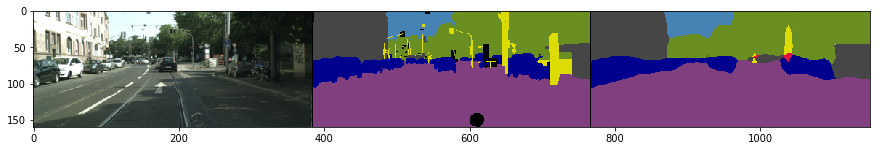

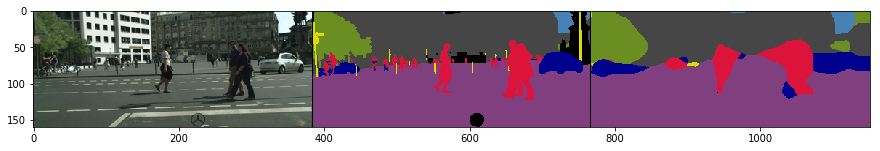

batch 000 loss = 0.36  (777.9 images/sec)
batch 010 loss = 0.38  (1050.0 images/sec)
batch 020 loss = 0.43  (864.1 images/sec)
batch 030 loss = 0.26  (848.8 images/sec)
batch 040 loss = 0.29  (838.4 images/sec)
[[11496863    56069    12949    33931      112    25475   135223]
 [  134777  5928891    27540   452243    81700    44898   196807]
 [   93163   459704    66359   251312    13430    25999    75978]
 [  113684   297172    14555  4940107    32092     8944    60303]
 [       3    36390     1343    52330   816015        2      788]
 [   51325    99135     4474    34637      209   200603    88605]
 [  137857   156914     6732    89561     2918    34514  2127545]]

 Validation  evaluation metrics:
	road IoU accuracy = 93.54 %
	building IoU accuracy = 74.37 %
	infrastructure IoU accuracy = 6.30 %
	nature IoU accuracy = 77.42 %
	sky IoU accuracy = 78.66 %
	person IoU accuracy = 32.42 %
	vehicle IoU accuracy = 68.33 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 61.58 %
Validat

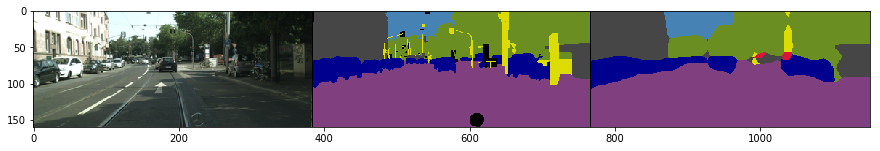

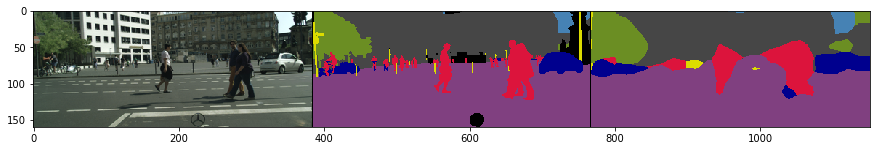

batch 000 loss = 0.35  (709.9 images/sec)
batch 010 loss = 0.37  (865.3 images/sec)
batch 020 loss = 0.42  (857.6 images/sec)
batch 030 loss = 0.26  (864.3 images/sec)
batch 040 loss = 0.30  (871.8 images/sec)
[[11471476    45612    22448    49711      128    36500   134747]
 [  139939  5876335    67788   475008    88940    51444   167402]
 [   87551   434767   111549   246758    14147    29605    61568]
 [   88631   268457    26252  4976097    42162    12282    52976]
 [       1    32863     3111    40237   829957       12      690]
 [   43367    99240     9276    31304      200   227763    67838]
 [  125503   172384    14665    93936     4082    45235  2100236]]

 Validation  evaluation metrics:
	road IoU accuracy = 93.68 %
	building IoU accuracy = 74.19 %
	infrastructure IoU accuracy = 9.88 %
	nature IoU accuracy = 77.71 %
	sky IoU accuracy = 78.55 %
	person IoU accuracy = 34.82 %
	vehicle IoU accuracy = 69.06 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 62.56 %
Validati

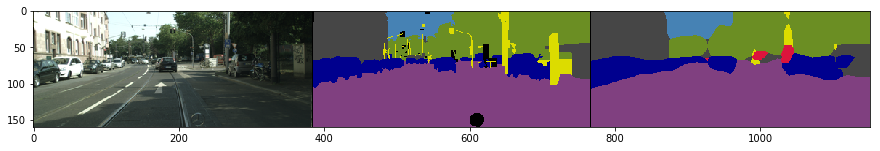

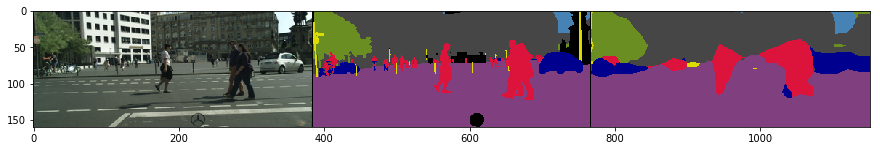

batch 000 loss = 0.36  (821.9 images/sec)
batch 010 loss = 0.38  (851.2 images/sec)
batch 020 loss = 0.42  (854.2 images/sec)
batch 030 loss = 0.26  (876.9 images/sec)
batch 040 loss = 0.28  (847.1 images/sec)
[[11455317    63877    19754    39386       71    40532   141685]
 [  121652  6051466    36119   312198    49946    59111   236364]
 [   84615   481417    89097   205223    12322    34928    78343]
 [   95528   390100    29887  4802883    40128    18537    89794]
 [       1    60333     2359    37870   804983        9     1316]
 [   40935    96182     5584    20498      100   237627    78062]
 [  120133   149752     9010    55126     1256    46592  2174172]]

 Validation  evaluation metrics:
	road IoU accuracy = 93.72 %
	building IoU accuracy = 74.63 %
	infrastructure IoU accuracy = 8.18 %
	nature IoU accuracy = 78.26 %
	sky IoU accuracy = 79.65 %
	person IoU accuracy = 35.01 %
	vehicle IoU accuracy = 68.34 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 62.54 %
Validati

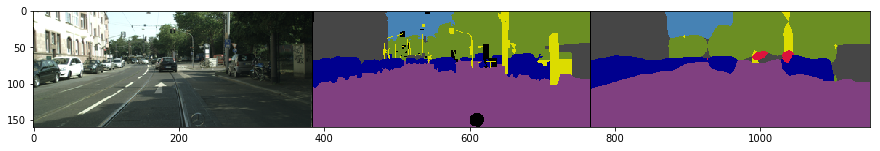

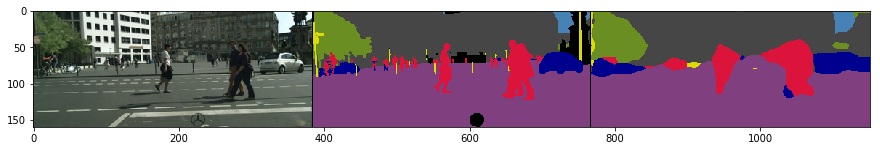

batch 000 loss = 0.36  (771.6 images/sec)
batch 010 loss = 0.39  (844.1 images/sec)
batch 020 loss = 0.42  (821.3 images/sec)
batch 030 loss = 0.26  (805.3 images/sec)
batch 040 loss = 0.29  (845.7 images/sec)
[[11435000    81422    20188    33464       63    34049   156436]
 [  101685  6142801    41857   316705    38761    46680   178367]
 [   83420   490242    95927   207598    10266    28453    70039]
 [   98791   384424    35554  4832425    33753    12902    69008]
 [       3    70967     4015    43064   787181       12     1629]
 [   43597   107117     6523    24080       81   218819    78771]
 [  106352   174522    11096    63562     1272    39109  2160128]]

 Validation  evaluation metrics:
	road IoU accuracy = 93.77 %
	building IoU accuracy = 75.14 %
	infrastructure IoU accuracy = 8.68 %
	nature IoU accuracy = 78.51 %
	sky IoU accuracy = 79.43 %
	person IoU accuracy = 34.18 %
	vehicle IoU accuracy = 69.45 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 62.74 %
Validati

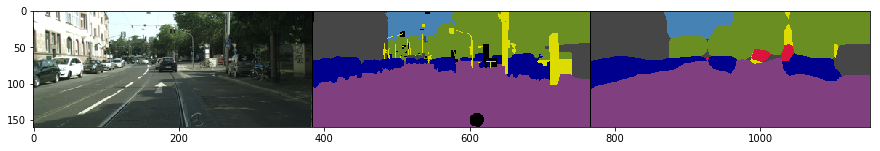

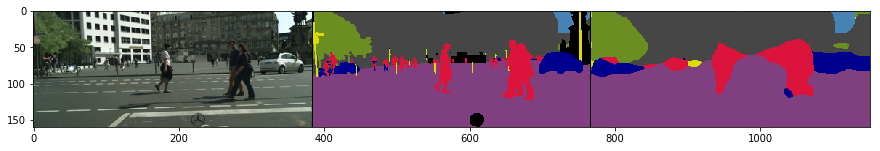

batch 000 loss = 0.35  (733.8 images/sec)
batch 010 loss = 0.37  (852.7 images/sec)
batch 020 loss = 0.42  (869.1 images/sec)
batch 030 loss = 0.25  (843.0 images/sec)
batch 040 loss = 0.29  (867.1 images/sec)
[[11539702    36179    16004    31861       76    37729    99071]
 [  170983  5940802    55715   356146    51440    75225   216545]
 [  102287   441353   105889   213237    11778    40612    70789]
 [  115086   329362    32167  4857730    35544    19927    77041]
 [       3    55536     3469    42699   803413       26     1725]
 [   49735    81089     5983    21410       87   248193    72491]
 [  163560   141842    10757    62885     1350    49472  2126175]]

 Validation  evaluation metrics:
	road IoU accuracy = 93.35 %
	building IoU accuracy = 74.71 %
	infrastructure IoU accuracy = 9.54 %
	nature IoU accuracy = 78.41 %
	sky IoU accuracy = 79.77 %
	person IoU accuracy = 35.36 %
	vehicle IoU accuracy = 68.73 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 62.84 %
Validati

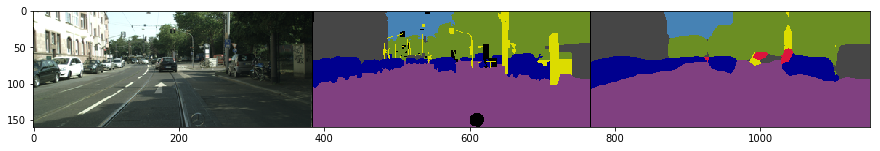

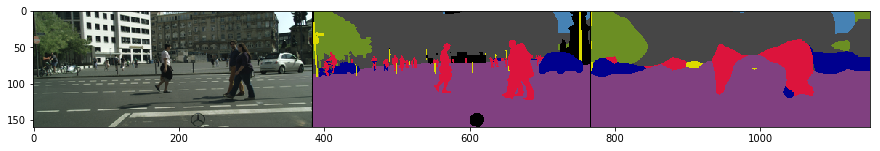

batch 000 loss = 0.36  (695.2 images/sec)
batch 010 loss = 0.37  (866.0 images/sec)
batch 020 loss = 0.41  (846.1 images/sec)
batch 030 loss = 0.26  (813.0 images/sec)
batch 040 loss = 0.29  (833.0 images/sec)
[[11478631    55737    24862    41544       73    35751   124024]
 [  137246  5968770    44571   395130    50941    53790   216408]
 [   85877   454727    98121   234192    12204    30332    70492]
 [   94888   308576    24700  4919084    34632    12529    72448]
 [       1    56252     1628    43515   804280       12     1183]
 [   44318    89676     7886    28722       97   223934    84355]
 [  131212   146415    12536    73922     1929    37164  2152863]]

 Validation  evaluation metrics:
	road IoU accuracy = 93.67 %
	building IoU accuracy = 74.81 %
	infrastructure IoU accuracy = 8.90 %
	nature IoU accuracy = 78.28 %
	sky IoU accuracy = 79.89 %
	person IoU accuracy = 34.53 %
	vehicle IoU accuracy = 68.89 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 62.71 %
Validati

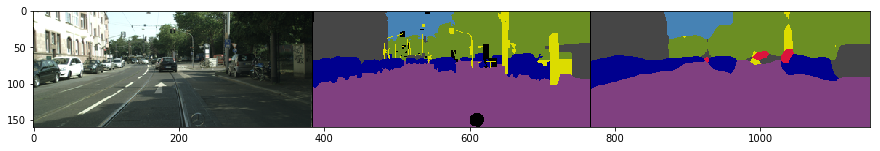

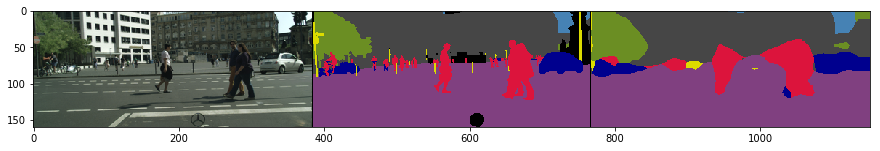

batch 000 loss = 0.35  (788.7 images/sec)
batch 010 loss = 0.37  (885.0 images/sec)
batch 020 loss = 0.41  (870.4 images/sec)
batch 030 loss = 0.26  (858.7 images/sec)
batch 040 loss = 0.28  (864.4 images/sec)
[[11477126    60354    28238    36996      129    43384   114395]
 [  124782  6036309    73266   358128    66780    59871   147720]
 [   83724   450066   131268   214339    12857    34159    59532]
 [  101453   336898    41942  4865563    45374    16078    59549]
 [       1    44217     3846    35514   822135       24     1134]
 [   41183    94488     9857    24320      165   246231    62744]
 [  134208   175228    17391    69345     2216    53716  2103937]]

 Validation  evaluation metrics:
	road IoU accuracy = 93.72 %
	building IoU accuracy = 75.19 %
	infrastructure IoU accuracy = 11.31 %
	nature IoU accuracy = 78.41 %
	sky IoU accuracy = 79.48 %
	person IoU accuracy = 35.88 %
	vehicle IoU accuracy = 70.11 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 63.44 %
Validat

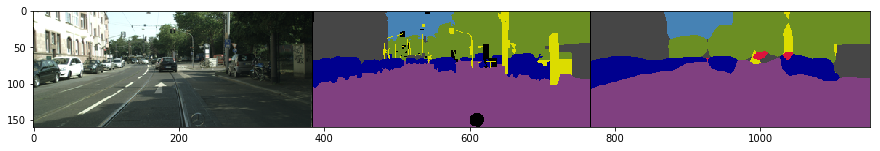

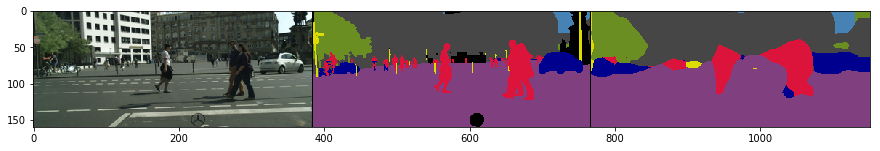

batch 000 loss = 0.35  (665.8 images/sec)
batch 010 loss = 0.37  (863.9 images/sec)
batch 020 loss = 0.41  (866.8 images/sec)
batch 030 loss = 0.25  (881.1 images/sec)
batch 040 loss = 0.28  (838.8 images/sec)
[[11456007    56426    27232    43545      104    32475   144833]
 [  119869  6024622    62781   341912    62508    48554   206610]
 [   83411   455500   121516   211251    12814    26671    74782]
 [   88282   343212    39260  4870955    40885    12413    71850]
 [       1    46273     2870    38817   817769       20     1121]
 [   45140    97186     9197    24385      136   217528    85416]
 [  110916   147938    14070    66198     2729    35639  2178551]]

 Validation  evaluation metrics:
	road IoU accuracy = 93.84 %
	building IoU accuracy = 75.18 %
	infrastructure IoU accuracy = 10.65 %
	nature IoU accuracy = 78.65 %
	sky IoU accuracy = 79.70 %
	person IoU accuracy = 34.27 %
	vehicle IoU accuracy = 69.37 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 63.09 %
Validat

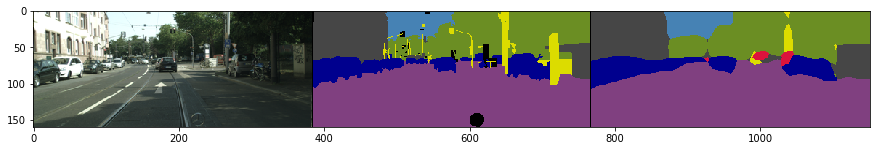

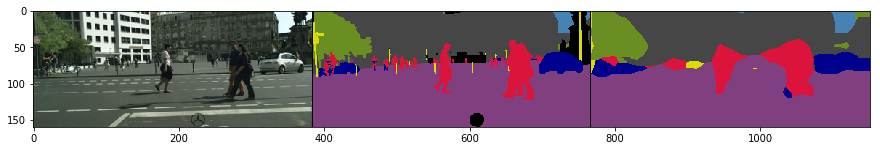

batch 000 loss = 0.35  (819.2 images/sec)
batch 010 loss = 0.37  (871.6 images/sec)
batch 020 loss = 0.41  (838.2 images/sec)
batch 030 loss = 0.26  (855.3 images/sec)
batch 040 loss = 0.28  (880.3 images/sec)
[[11471785    56924    29003    38030       85    38017   126778]
 [  121340  6062635    64866   349880    57688    54779   155668]
 [   83633   458896   124838   214355    12380    31214    60629]
 [   95821   342231    40118  4875856    38457    14797    59577]
 [       3    49298     3149    40445   812844       18     1114]
 [   43316    97876     9941    24829      127   237443    65456]
 [  120576   175508    17139    70648     2452    48812  2120906]]

 Validation  evaluation metrics:
	road IoU accuracy = 93.84 %
	building IoU accuracy = 75.33 %
	infrastructure IoU accuracy = 10.85 %
	nature IoU accuracy = 78.58 %
	sky IoU accuracy = 79.84 %
	person IoU accuracy = 35.62 %
	vehicle IoU accuracy = 70.11 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 63.45 %
Validat

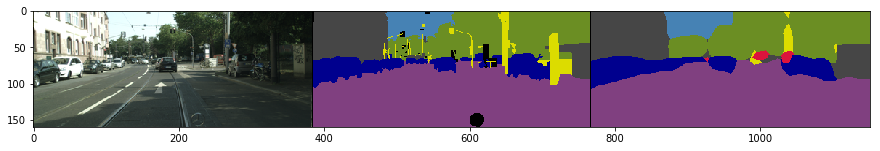

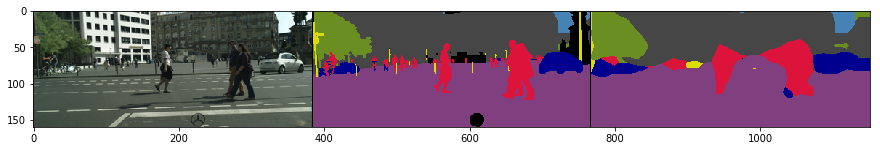

batch 000 loss = 0.35  (832.6 images/sec)
batch 010 loss = 0.37  (867.0 images/sec)
batch 020 loss = 0.41  (868.8 images/sec)
batch 030 loss = 0.26  (867.0 images/sec)
batch 040 loss = 0.28  (869.2 images/sec)
[[11471983    58288    27855    37569       83    35667   129177]
 [  119563  6086871    64100   329670    55943    50809   159900]
 [   84427   465098   125310   207020    12295    29075    62720]
 [   96130   360460    43770  4851168    38257    14007    63065]
 [       3    50620     3016    40385   811631       18     1198]
 [   44566   101007    10004    23679      121   230827    68784]
 [  120119   174912    16926    65891     2265    44704  2131224]]

 Validation  evaluation metrics:
	road IoU accuracy = 93.84 %
	building IoU accuracy = 75.36 %
	infrastructure IoU accuracy = 10.88 %
	nature IoU accuracy = 78.61 %
	sky IoU accuracy = 79.90 %
	person IoU accuracy = 35.33 %
	vehicle IoU accuracy = 70.09 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 63.43 %
Validat

In [8]:
num_epochs = 30
batch_size = 10
save_dir = 'local/output/'

learning_rate = 1e-3
decay_power = 1.0

global_step = tf.Variable(0, trainable=False)
decay_steps = num_epochs * train_data.num_batches

lr = tf.train.polynomial_decay(learning_rate, global_step, decay_steps,
                               end_learning_rate=0, power=decay_power)

train_step = tf.train.AdamOptimizer(lr).minimize(loss, global_step=global_step)

log_dir = 'local/logs'
checkpoint_dir = 'local/checkpoints'
utils.clear_dir(log_dir)
utils.clear_dir(checkpoint_dir)

saver = tf.train.Saver()

sess = tf.Session()

summary_all = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(join(log_dir, 'train'), sess.graph)

tf.global_variables_initializer().run(session=sess)

step = 0
best_iou = 0
best_epoch = 0
exp_start_time = time.time()
for epoch in range(1, num_epochs+1):
    # confusion_mat = np.zeros((num_classes, num_classes), dtype=np.uint64)
    print('\nTraining phase:')
    for x_np, y_np, names in train_data:
        start_time = time.time()
        loss_np, summary, _ = sess.run([loss, summary_all, train_step],
        feed_dict={x: x_np, y: y_np})
        train_writer.add_summary(summary, step)
        duration = time.time() - start_time
        # confusion_mat += batch_conf_mat.astype(np.uint64)
        if step % 20 == 0:
            string = '%s: epoch %d / %d, iter %05d, loss = %.2f  (%.1f images/sec)' % \
            (utils.get_expired_time(exp_start_time), epoch, num_epochs, step, loss_np, batch_size / duration)
            print(string)
        step += 1
    # utils.print_metrics(confusion_mat, 'Train') 
    iou = validate(val_data, x, y, y_pred, loss, draw_steps=2)
    if iou > best_iou:
        best_iou, best_epoch = iou, epoch
        save_path = saver.save(sess, join(checkpoint_dir, 'model.ckpt'))
        print('Model saved in file: ', save_path)
    print('\nBest IoU = %.2f (epoch %d)' % (best_iou, best_epoch))

## 4. Restoring the trained network

INFO:tensorflow:Restoring parameters from local/checkpoints/model.ckpt

Validation phase:


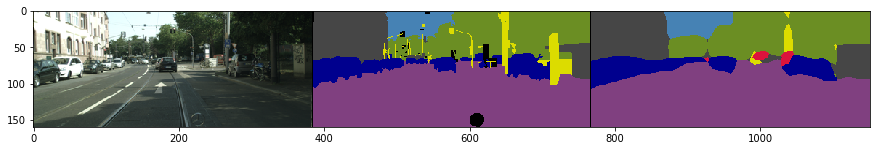

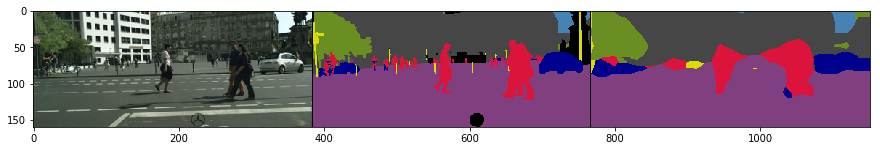

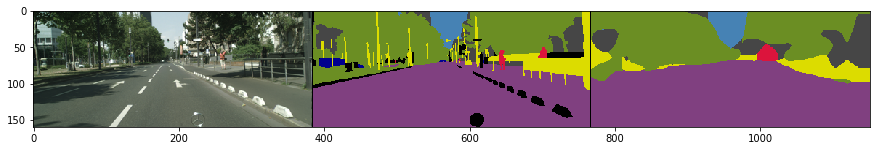

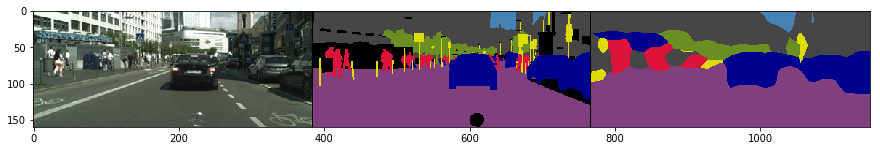

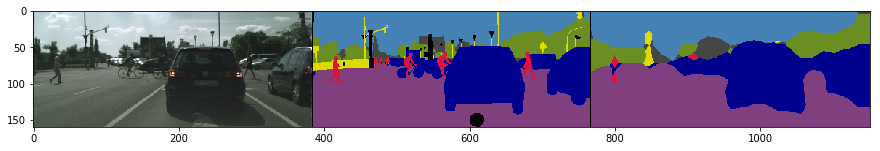

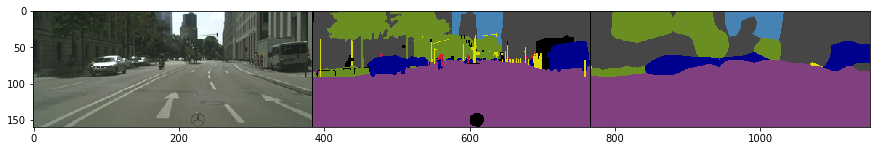

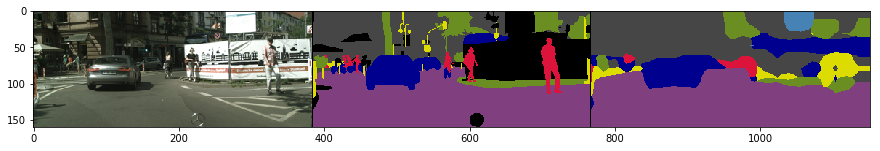

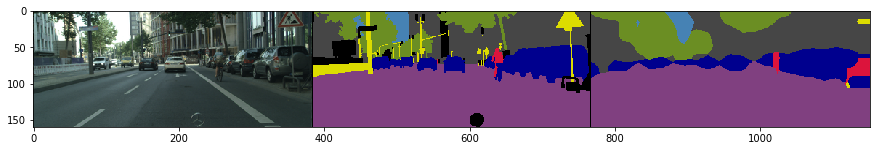

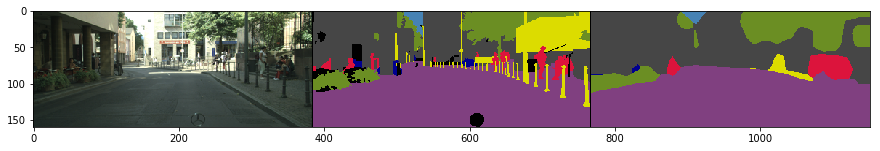

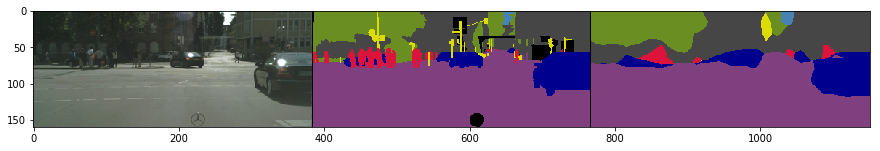

batch 000 loss = 0.35  (823.4 images/sec)
batch 010 loss = 0.37  (833.0 images/sec)
batch 020 loss = 0.41  (829.3 images/sec)
batch 030 loss = 0.26  (833.3 images/sec)
batch 040 loss = 0.28  (832.1 images/sec)
[[11471785    56924    29003    38030       85    38017   126778]
 [  121340  6062635    64866   349880    57688    54779   155668]
 [   83633   458896   124838   214355    12380    31214    60629]
 [   95821   342231    40118  4875856    38457    14797    59577]
 [       3    49298     3149    40445   812844       18     1114]
 [   43316    97876     9941    24829      127   237443    65456]
 [  120576   175508    17139    70648     2452    48812  2120906]]

 Validation  evaluation metrics:
	road IoU accuracy = 93.84 %
	building IoU accuracy = 75.33 %
	infrastructure IoU accuracy = 10.85 %
	nature IoU accuracy = 78.58 %
	sky IoU accuracy = 79.84 %
	person IoU accuracy = 35.62 %
	vehicle IoU accuracy = 70.11 %
Validation IoU mean class accuracy - TP / (TP+FN+FP) = 63.45 %
Validat

63.453090725125165

In [9]:
# restore the best checkpoint
checkpoint_path = join(checkpoint_dir, 'model.ckpt')
saver.restore(sess, checkpoint_path)
validate(val_data, x, y, y_pred, loss, draw_steps=10)

## Day 4

## 5. Improved model with skip connections

TODO slika

In [10]:
sess.close()
tf.reset_default_graph()
build_model()
train again

SyntaxError: invalid syntax (<ipython-input-10-3809f32067eb>, line 4)